In [1]:
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import imutils
from os import listdir
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
def data_summary():
          
    m_dry = len(listdir(r'A:/TechieYan projects/AI/EYE_ARMD/resized_dryamd_images'))
    m_wet = len(listdir(r'A:/TechieYan projects/AI/EYE_ARMD/resized_wetamd_images'))
    m_nor = len(listdir(r"A:/TechieYan projects/AI/EYE_ARMD/resized_normal_images"))
    m = (m_dry + m_wet + m_nor)
    
    dry_prec = (m_dry* 100.0)/ m
    wet_prec = (m_wet* 100.0)/ m
    nor_perc = (m_nor * 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of WET_ARMD examples: {wet_prec}%, number of wet examples: {m_wet}") 
    print(f"Percentage of DRY_ARMD examples: {dry_prec}%, number of dry examples: {m_dry}")
    print(f"Percentage of NORMAL examples: {nor_perc}%, number of normal examples: {m_nor}")  

In [5]:
data_summary()

Number of examples: 7177
Percentage of WET_ARMD examples: 31.322279503971018%, number of wet examples: 2248
Percentage of DRY_ARMD examples: 31.01574474014212%, number of dry examples: 2226
Percentage of NORMAL examples: 37.661975755886864%, number of normal examples: 2703


## Cropping the image

In [6]:
def crop_disease_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

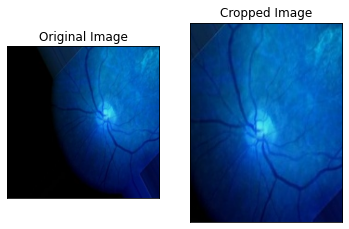

In [7]:
ex_img = cv2.imread(r"A:/TechieYan projects/AI/EYE_ARMD/resized_dryamd_images/images8.jpg")
# path = r"C:/EYE_ARMD/resized_wetamd_images/image_0.jpg"
ex_new_img = crop_disease_contour(ex_img, True)

In [8]:
# Here we create a dict which consists label for each image path and its particular data.
def load_file(file_path, label):

    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    # load every file that .png format
    for image_path in glob.glob(file_path + "/*.*"):
        # read image file
        image = imageio.imread(image_path)
        # declare temporary dict dtype
        temp = {}
        # set the file name
        temp["name"] = image_path.split("/")[-1]
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:   
            temp["data"] = image[:,:,0].astype("int") 
        except:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)
    # print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    # convert list into numpy array dtype
    return np.array(out_list)

In [9]:
m_dry_path = r'A:/TechieYan projects/AI/EYE_ARMD/resized_dryamd_images'
m_wet_path = r'A:/TechieYan projects/AI/EYE_ARMD/resized_wetamd_images'
m_nor_path = r"A:/TechieYan projects/AI/EYE_ARMD/resized_normal_images"

In [10]:
dry_images = load_file(file_path = m_dry_path, label = 0)
wet_images = load_file(file_path = m_wet_path, label = 1)
nor_images = load_file(file_path = m_nor_path, label = 2)

loading file from folder: resized_dryamd_images is successful
loading file from folder: resized_wetamd_images is successful
loading file from folder: resized_normal_images is successful


In [11]:
dry_images.shape

(2226,)

In [12]:
wet_images.shape

(2248,)

In [13]:
nor_images.shape

(2703,)

In [14]:

dry_images

array([{'name': 'resized_dryamd_images\\images0.jpg', 'label': 0, 'data': Array([[50, 54, 54, ...,  0,  0,  0],
              [51, 54, 54, ...,  0,  0,  0],
              [52, 55, 56, ...,  0,  0,  0],
              ...,
              [82, 84, 85, ...,  0,  0,  0],
              [84, 85, 85, ...,  0,  0,  0],
              [85, 85, 85, ...,  0,  0,  0]])}                                                                 ,
       {'name': 'resized_dryamd_images\\images1.jpg', 'label': 0, 'data': Array([[ 21,  29,  35, ...,   0,   0,   0],
              [ 21,  29,  36, ...,   0,   0,   0],
              [ 22,  30,  37, ...,   0,   0,   0],
              ...,
              [135, 137, 139, ...,   0,   0,   0],
              [136, 137, 140, ...,   0,   0,   0],
              [135, 137, 140, ...,   0,   0,   0]])}                                                                 ,
       {'name': 'resized_dryamd_images\\images10.jpg', 'label': 0, 'data': Array([[82, 82, 81, ...,  8,  8,  8],
   

In [13]:
type(dry_images)

numpy.ndarray

In [15]:
np.random.shuffle(dry_images)
np.random.shuffle(wet_images)
np.random.shuffle(nor_images)

A = dry_images
B = wet_images
C = nor_images


# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if A.shape[0] <= B.shape[0] <= C.shape[0]:
  class_size = A.shape[0]
elif B.shape[0] <= A.shape[0] <= C.shape[0]:
  class_size = B.shape[0]
else:
  class_size = C.shape[0]
print("Class Size:", class_size)


Class Size: 2226


In [16]:
dataset = np.concatenate((dry_images[:class_size], wet_images[:class_size], nor_images[:class_size]))
dataset.shape

(6678,)

In [17]:
dry_images[0]['data'].shape

(255, 255)

In [17]:
### Session was crashing with these amount of images, so i have taken sample of 1500 images.

In [18]:
# we shuffle the order of defect-free and defect images
np.random.shuffle(dry_images)
np.random.shuffle(wet_images)
np.random.shuffle(nor_images)

# the class size is the min length compared with wet, dry and normal images, we do this in order to balance the dataset.
if A.shape[0] <= B.shape[0] <= C.shape[0]:
  class_size = A.shape[0]
elif B.shape[0] <= A.shape[0] <= C.shape[0]:
  class_size = B.shape[0]
else:
  class_size = C.shape[0]
print("Class Size:", class_size)

# Concatenate both the datasets with size as class_size.
dataset = np.concatenate((dry_images[:class_size], wet_images[:class_size], nor_images[:class_size]))

# create an empty matrix X of 256x4096 and has dataset length row, which holds all the data i.e images from dataset.
# Independent Features -> X
X = np.empty([dataset.shape[0], 255, 255]).astype(int)

# create vector y which has dataset length, which holds all the labels for our data, this is jsut similar to partitioning the data before splitting, 
# Target_variable -> y
y = np.empty(dataset.shape[0]).astype(int)

# assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# since Keras acquire the Image input in a tensor type -> we reshape X
X = X.reshape(X.shape[0], 255, 255, 1)
print(X.shape)

# display size of the label 0 and label 1 
np.unique(y, return_counts=True)


Class Size: 2226
(6678, 255, 255, 1)


(array([0, 1, 2]), array([2226, 2226, 2226], dtype=int64))

# loading and plotting the data.


In [19]:
def plot_sample_images(X, y, n=50):

    
    for label in [0,1,2]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        i = 1 
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            i += 1
        plt.suptitle(f"EYE ARMD: {(label)}")
        plt.show()

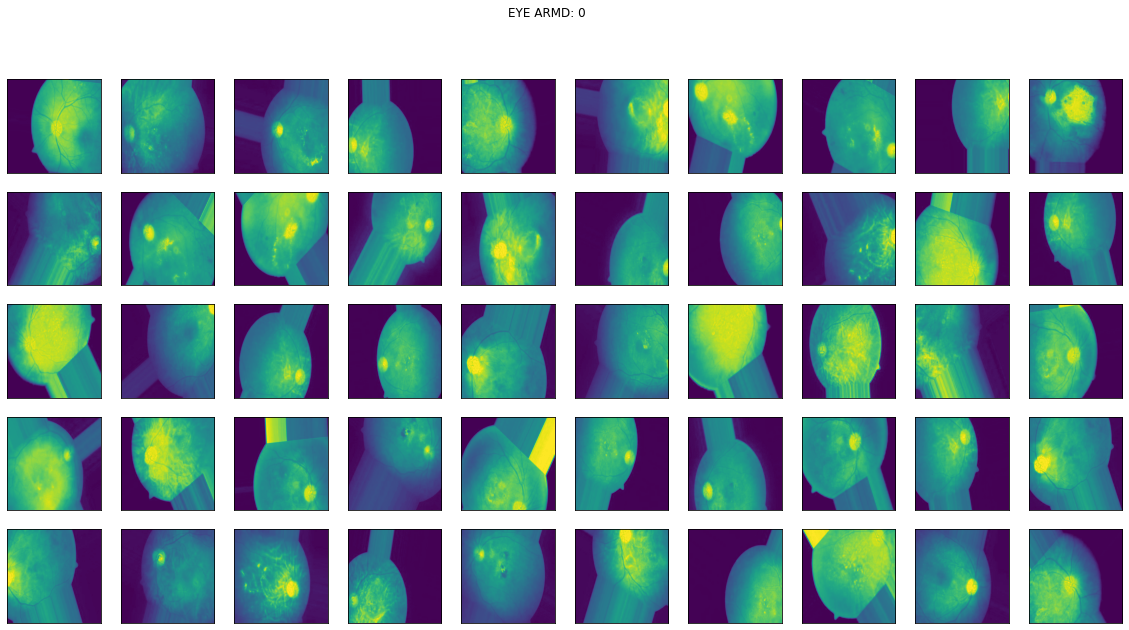

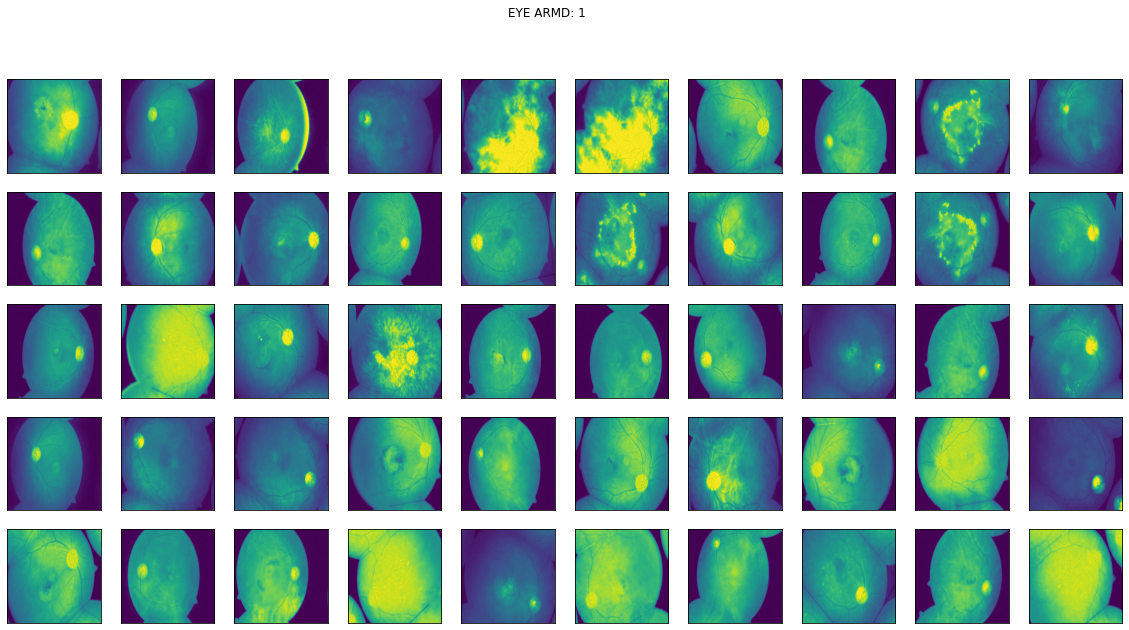

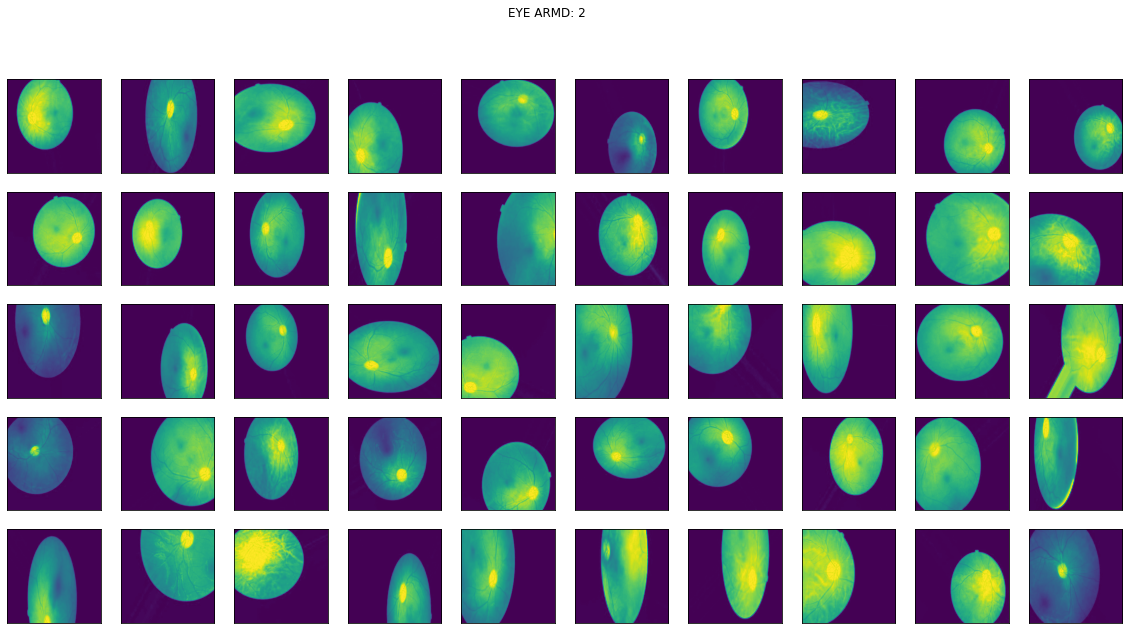

In [20]:
plot_sample_images(X, y)

## **Model Building**

In [21]:
def create_model(image_shape=(256, 4096, 1), print_summary=True):
    # initial model
    model = models.Sequential()

    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(16, (3, 3),input_shape=image_shape))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))


    # CONV layer: filter 32, stride 5x5
    model.add(layers.Conv2D(32, (3, 3), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))
    
    
    # CONV layer: filter 64, stride 5x5
    model.add(layers.Conv2D(64, (3,3), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.10))

   
    # flatten layer -> To convert from matrix to vector ie from multidimensional array to 1D array with single column.
    model.add(layers.Flatten())
    

    # Here we are creating an actual neural network which takes input as the flatten layer.
    # fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(500))
    # Batch Normalization layer -> avoid overfitting
    # model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    # model.add(layers.Dropout(0.25))


    # Here we are creating an actual neural network which takes input as the flatten layer.
    # fully connected layer -> nn layer with 12 nodes
    model.add(layers.Dense(250))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.10))


    model.add(layers.Dense(3, activation='sigmoid'))


    # set model compiler
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # show the CNN model detail
    if print_summary:
        model.summary()
    return model


def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # train CNN model
    # batch size to reduce memory usage
    # set early stopping to avoid overfitting
    
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=2)
    filepath = "A:/TechieYan projects/AI/EYE_ARMD/model/weights-best-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, earlystopping]

    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[callbacks_list])
    return history

create_model(image_shape=(255, 255, 1), print_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 253, 253, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      4

## Train and Export CNN Model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=23)
print("X_train: number of samples each class: {}".format(np.unique(y_train, return_counts=True)))
print("X_test: number of samples each class: {}".format(np.unique(y_test, return_counts=True)))

X_train: number of samples each class: (array([0, 1, 2]), array([2019, 2002, 1989], dtype=int64))
X_test: number of samples each class: (array([0, 1, 2]), array([207, 224, 237], dtype=int64))


In [23]:
cnn_model = None
cnn_model = create_model(image_shape=(255, 255, 1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 253, 253, 16)      160       
                                                                 
 batch_normalization_4 (Batc  (None, 253, 253, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 253, 253, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 126, 126, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 32)     

In [24]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20)
filepath = "A:/TechieYan projects/AI/EYE_ARMD/model/weights_best_val.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, earlystopping]

In [26]:
# cnn_model.fit(X_train, y_train, batch_size=15, epochs=20, validation_split=0.1, callbacks=callbacks_list)

In [25]:
new_model = tf.keras.models.load_model("A:/TechieYan projects/AI/EYE_ARMD/model/weights_best_val_96_255.hdf5")

In [26]:
score, acc = new_model.evaluate(X_test, y_test, verbose=0)
score, acc

(0.03446447104215622, 0.9865269660949707)

In [27]:
demo = new_model.predict(X_test)
demo

array([[9.9915731e-01, 1.2909952e-01, 1.3743043e-03],
       [6.1273545e-01, 9.9999154e-01, 3.0376242e-07],
       [9.9813133e-01, 2.3237556e-02, 5.9176087e-03],
       ...,
       [1.8680844e-01, 9.9791801e-01, 6.9261789e-03],
       [1.9128174e-02, 9.9994743e-01, 4.8333406e-04],
       [2.5383908e-01, 1.6787052e-03, 9.9847305e-01]], dtype=float32)

In [45]:
count = len(demo)
y_pred = []
for i in range(count):
    if np.argmax(demo[i]) == 0:
        y_pred.append(0)
    elif np.argmax(demo[i]) == 1:
        y_pred.append(1)
    else:
        y_pred.append(2)

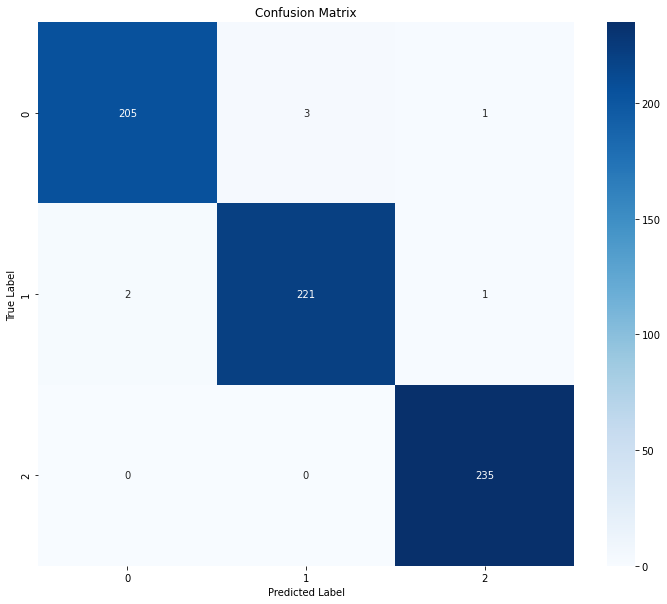

In [48]:
    plt.figure(figsize = (12,10))
    cf_matrix = confusion_matrix(y_pred,y_test)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

path = r"A:/TechieYan projects/AI/EYE_ARMD/augmented_normal_images/image_0_2.jpg"
img = plt.imread(path)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(img_gray, (5, 5), 0)   
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
img_half = cv2.resize(img, (255, 255))
img_half = cv2.cvtColor(img_half, cv2.COLOR_BGR2GRAY)
x = img_to_array(img_half)
x = np.array(x).reshape(-1, 255, 255, 1)

In [29]:
prediction = new_model.predict(x)
# np.argmax(prediction)
if np.argmax(prediction) == 0:
    print("YES, DRY")
elif np.argmax(prediction) == 1:
    print("YES, WET")
else:
    print("NO, NORMAL")

NO, NORMAL
